In [1]:
from common import *
from search.imports import *
from search.search import *
from search.manager import ModelManager
from features.bank import TP

from features import Features
import scipy as sp

In [2]:
import globals as top_imports
top_imports.use_M = False
from given import *

In [3]:
#F, P = pd.read_pickle(big_data/'saves/train_5fixedsince+2.32.pkl')
#setup_P(F=F,P=P)
bigF = Features()

# gotta define some stuff

In [4]:
def get_name(q):
    return q[q.index('<')+1:q.index('>')]

In [5]:
@njit
def sharpe(x):
    mean = x.mean()
    std = x.std()
    std = std if std != 0 else 1.
    return mean/std

In [6]:
quarter = lambda time: (lambda time: (time.dt.year+(time.dt.quarter-1)/4).astype(np.float32))(pd.Series(time))
halfYear = lambda time: (quarter(time)*2).astype(int).values/2

In [7]:
TIME = O(lo=np.datetime64('2009-01-02T22:00:00.000000000'),hi=np.datetime64('2016-12-30T22:00:00.000000001')+1)
HALFYEAR = O(lo=2009.,hi=2017.)

@njit
def in_interval(x, lo, hi):
    return (lo<=x)&(x<hi)
    #return True if lo==None and hi==None else x<hi if lo is None else lo<=x if hi is None else (lo<=x)&(x<hi)

@njit
def make_blocks(values, lo, hi, get_values=True):
    '''Return [] of (start,end(excl)) indices of blocks of same values in `values`'''
    ans = []
    if get_values:
        ret = []
    i = 0
    prev_x = values[0]
    for i,x in enumerate(values):
        if i==0:
            start = i
            prev_x = x
        elif prev_x!=x:
            if in_interval(prev_x,lo,hi):
                ans.append((start,i))
                if get_values:
                    ret.append(prev_x)
            start = i
            prev_x = x
    if in_interval(prev_x,lo,hi):
        ans.append((start,len(values)))
        if get_values:
            ret.append(prev_x)
    return (ans,ret)# if get_values else ans

@njit
def blocks_sharpe(blocks, values):
    return [sharpe(values[i:j]) for i,j in blocks]

@njit
def mean_blocks_sharpe(blocks, values):
    return np.array([sharpe(values[i:j]) for i,j in blocks]).mean()

@njit
def cv_ho_scores(blocks, values):
    return mean_blocks_sharpe(blocks[2:-3],values), mean_blocks_sharpe(blocks[-3:],values) #CVHO

In [8]:
def change_index(func=None, name=None):
    #assert not func is None and name is None, '`change_index` must either change index or the name!'
    if func is None:
        func = lambda x: x
    def change(x):
        x.index = func(x.index)
        if name is not None:
            x.index.name = name
        return x
    return change

def make_sharpes_function(lo=None, hi=None):
    lo = lo if lo is not None else HALFYEAR.lo
    hi = hi if hi is not None else HALFYEAR.hi
    def sharpes(x, *, group=None, blocks=None):
        group_name = group.name if hasattr(group, 'name') else 'halfYear'
        if blocks is not None:
            pass
        elif group is not None and not isinstance(group, np.ndarray):
            group = group.values
        elif group is None:
            group = halfYear(x.index)
        
        if not isinstance(x, np.ndarray):
            x = x.values
            
        if blocks is None:
            blocks, block_values = make_blocks(group, lo=lo, hi=hi, get_values=True)
            
        data = blocks_sharpe(blocks, x)
        
        return pd.Series(data, index=block_values).pipe(change_index(name=group_name))
    return sharpes
#CVHO
cv = make_sharpes_function(lo=2010.,hi=2015.5)
ho = make_sharpes_function(lo=2015.5)

### set the models to blend

In [9]:
q_ = []
q_ += [getattr(TP,x) for x in 'ikg IKGZen IKGHomo IKGZenTenDraw IKGHomoTenDraw IKGZenVolatility IKGHomoVolatility'.split()]
q_ += [getattr(TP,x) for x in 'Another Global IKGHomoThree IKGZenThree IKGZenThreeVP1 IKGZenThreeMoreShort'.split()]
q_ += [getattr(TP,x) for x in 's20 s21 s22 s00 s10 s11'.split()]
q_ += [getattr(TP,x) for x in 'IKGCover TryIt IKGCoverThreeVP1 IKGCoverThreeMoreShort'.split()]

In [10]:
# qq_ = []
# qq_ += [TP.PairFiveShortVP1_1_0_0_NoCorr]

# Load up the models

In [11]:
DIR = '/big/data/amour/'

In [12]:
ans = []
nbests = []

mm = ModelManager(DIR+'flat')
for q in q_:
    name = get_name(q)
    f, _ = bigF.query_solo(q)
    fi = mm.F.i(Feats=f)
    pm = mm.iPM(fi, 0)
    nbest = pm.get('Results', i=0).nbest
    guy = pm.get('Answers', i=0)
    res = pd.concat([guy[i][0] for i in range(len(guy)-1)]+guy[-1][1:], axis=0)
    ans.append(res)
    nbests.append(nbest)

mm = ModelManager(DIR+'vp10')
for q in q_:
    name = get_name(q)
    f, _ = bigF.query_solo(q)
    fi = mm.F.i(Feats=f)
    pm = mm.iPM(fi, 0)
    nbest = pm.get('Results', i=0).nbest
    guy = pm.get('Answers', i=0)
    res = pd.concat([guy[i][0] for i in range(len(guy)-1)]+guy[-1][1:], axis=0)
    ans.append(res)
    nbests.append(nbest)
    
# Pair = O(lo=(.55, 500), hi=None, repeat=2)
# tag = f'pair,{Pair.lo},{Pair.hi},{Pair.repeat}'
# mm = ModelManager(DIR+tag)
# for q in qq_:
#     name = get_name(q)
#     fi = 0
#     pm = mm.iPM(fi, 0)
#     nbest = pm.get('Results', i=0).nbest
#     guy = pm.get('Answers', i=0)
#     res = pd.concat([guy[i][0] for i in range(len(guy)-1)]+guy[-1][1:], axis=0)
#     ans.append(res)
#     nbests.append(nbest)

In [13]:
names = ['a'+get_name(q) for q in q_] + ['m'+get_name(q) for q in q_]# + ['p'+get_name(q) for q in qq_]

In [14]:
def get_daily(df):
    WEIGHT = 'flat_weight' if 'flat_weight' in df else 'vp10_weight'
    df['trade'] = (df.target*2-1) * df[WEIGHT] * df.guess.fillna(0)
    return df.groupby('time')[['trade']].sum()

In [15]:
# p = P[P.quarter>=2010]
d = None
my = None
for name, res in zip(names, ans):
    if d is None:
        d = get_daily(res).rename(columns={'trade':name})
        my = res.copy()
        my.rename(columns={'guess':name},inplace=True)
        del my['trade']
    else:
        d[name] = get_daily(res).iloc[:,0]
        my[name] = res.guess
        if 'vp10_weight' in res and 'vp10_weight' not in my:
            my['vp10_weight'] = res.vp10_weight
my['upDown'] = my.target*2-1

# Exploit what we have

In [97]:
d = e

In [119]:
# paircol = 'pPairFiveShortVP1_1_0_0_NoCorr'
# cols = ['m'+x for x in 's20 s21 s22 s00 s10 s11 IKGCover TryIt IKGCoverTenDraw IKGCoverThreeMoreShort'.split()]
# cols += ['a'+x for x in 's20 s21 s22 s00 s10 s11 IKGCover TryIt IKGCoverTenDraw IKGCoverThreeMoreShort'.split()]
# d = d['ms10 as21 aTryIt aIKGCoverThreeMoreShort'.split() + []]
d = d[
# 'aGlobal '#'aAnother '
'aTryIt '#1#'aikg '
'as21 '#'as10 '#'as20 '#'as21 as22 as10 as11 '
'aIKGHomoTenDraw '#'aIKGHomoThree '#'aIKGHomo aIKGHomoVolatility '
'aIKGZenThreeMoreShort '#'aIKGZenTenDraw 'aIKGZen '#'aIKGZenVolatility ' #'aIKGZenThreeVP1 aIKGZenThreeMoreShort '
# 'aIKGCoverThreeVP1 '#'aIKGCover aTryIt aIKGCoverThreeMoreShort '
#'mGlobal '#'mAnother '
#'mikg '#'mTryIt '
'ms10 '#'ms21 '#'ms20 '#'as22 as10 as11 '
#'mIKGHomoTenDraw mIKGHomoThree '#'aIKGHomo aIKGHomoVolatility '
#'mIKGZenThreeMoreShort '#'aIKGZenTenDraw 'aIKGZen '#'aIKGZenVolatility ' #'aIKGZenThreeVP1 aIKGZenThreeMoreShort '
#'mIKGCover '#'aTryIt aIKGCoverThreeVP1 aIKGCoverThreeMoreShort '
''.split()]

In [120]:
_DO_IT_ = True

In [121]:
%%time
if _DO_IT_:
    n = 1_000_000
    cc = np.random.exponential(size=(n,d.shape[1]))
    cc /= cc.sum(axis=1)[:,None]
    dd = d.values
    blocks, _ = make_blocks(halfYear(d.index.values), HALFYEAR.lo, HALFYEAR.hi)
    scores = [cv_ho_scores(blocks, dd@c) for c in cc]
    ibest = sorted(range(n), key=lambda i: scores[i][0], reverse=True)
_DO_IT_ = False

CPU times: user 42.5 s, sys: 49.1 ms, total: 42.5 s
Wall time: 14.8 s


In [122]:
list(zip(d.columns, cc[ibest[0]]))

[('aTryIt', 0.11180278725087089),
 ('as21', 0.20885180829431121),
 ('aIKGHomoTenDraw', 0.038559962770245995),
 ('aIKGZenThreeMoreShort', 0.00062550540392620438),
 ('ms10', 0.6401599362806456)]

In [123]:
%matplotlib inline
canvas(18,6)

(0.7499714795888053, 0.6792319124953048)


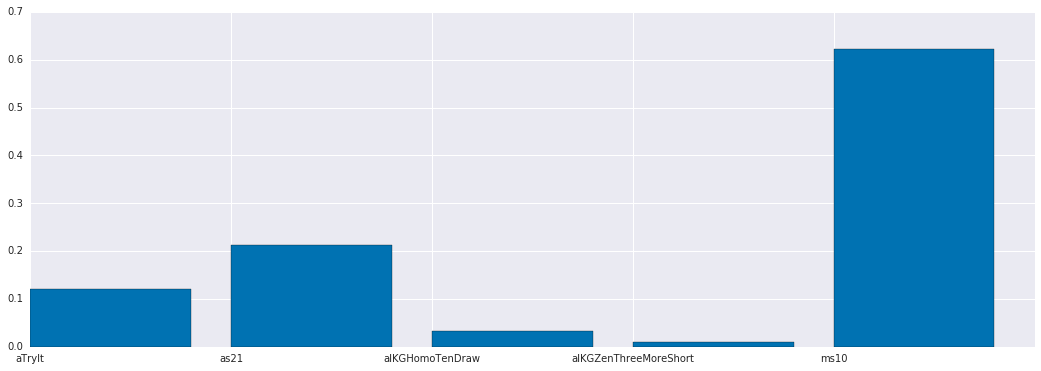

In [124]:
k = 11
print(scores[ibest[k]])
plt.bar(np.arange(d.shape[1]), tick_label=d.columns, height=cc[ibest[k]]);

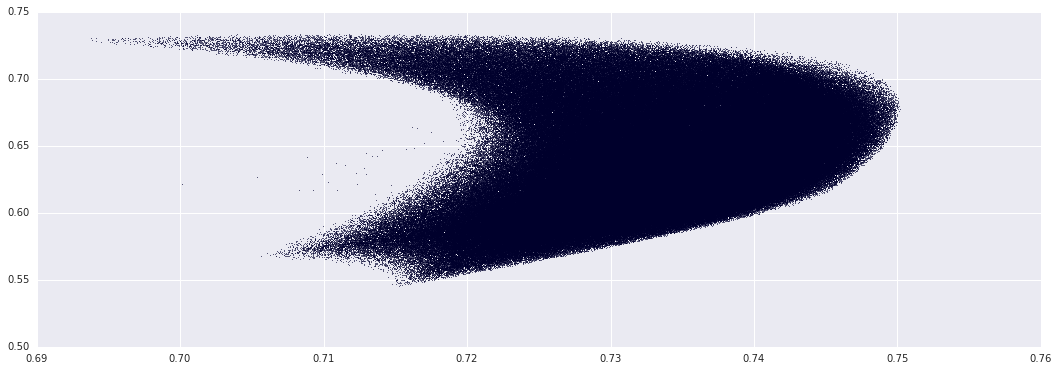

In [125]:
guys = np.asarray([[scores[i][0], scores[i][1]] for i in ibest[::]])
plt.scatter(guys[:,0], guys[:,1], s=.3);

# Hardcore weight optimization

In [186]:
check = []
e = None
for name in names:
    my['trade'] = my[name] * my.upDown*(my.flat_weight if name[0]!='m' else my.vp10_weight)
    what = my[my.assetCodeId.isin(xStocksAlways)].groupby('time')[['trade']].sum()
    
    if e is None:
        e = what.rename(columns={'trade':name})
    else:
        e[name] = what.trade
    
    what = what.trade
    check.append([cv(what).mean(), ho(what).mean()])
    print(name, check[-1])
check = np.asarray(check)

aikg [0.6713985118520424, 0.601728359389942]
aIKGZen [0.6629494799807872, 0.5654265092002964]
aIKGHomo [0.6728052456955106, 0.558763754163354]
aIKGZenTenDraw [0.6712958592321283, 0.5475063221742252]
aIKGHomoTenDraw [0.6707268633842441, 0.5507366800676392]
aIKGZenVolatility [0.6434545537650672, 0.594773644998118]
aIKGHomoVolatility [0.6457645108526627, 0.6142894478280679]
aAnother [0.6179637193992611, 0.5899911577310067]
aGlobal [0.6337911703203958, 0.5206759268989894]
aIKGHomoThree [0.673127391724558, 0.5590454948778575]
aIKGZenThree [0.6790985614118483, 0.5625225233319234]
aIKGZenThreeVP1 [0.6793329941487896, 0.5565950727570914]
aIKGZenThreeMoreShort [0.6762546439821832, 0.5484055457728615]
as20 [0.6107766233883665, 0.6172458580263295]
as21 [0.6543054597560464, 0.5207496964625892]
as22 [0.6689308051352357, 0.6570425554788503]
as00 [0.6642131850926275, 0.6139524728849851]
as10 [0.6658795130391565, 0.5388937948181144]
as11 [0.6635669625718394, 0.5337759924859015]
aIKGCover [0.6699160114

In [187]:
check = []
e = None
for name in names:
    my['testing'] = my.groupby('time')[name].transform(lambda x: np.tanh((x-x.mean())*3))
    my['test'] = my.testing * my.upDown*(my.flat_weight if name[0]!='m' else my.vp10_weight)
    what = my.groupby('time')[['test']].sum()
    
    if e is None:
        e = what.rename(columns={'test':name})
    else:
        e[name] = what.test
    
    what = what.test
    check.append([cv(what).mean(), ho(what).mean()])
    print(name, check[-1])
check = np.asarray(check)

aikg [0.6990770724534584, 0.6049070537914182]
aIKGZen [0.6831486297940336, 0.5738657696019182]
aIKGHomo [0.7031529542005357, 0.5717011167832066]
aIKGZenTenDraw [0.6961257357150621, 0.5515938595444512]
aIKGHomoTenDraw [0.7128040280376713, 0.5527884172638716]
aIKGZenVolatility [0.6764421196788112, 0.5917727608238686]
aIKGHomoVolatility [0.6920081821399484, 0.601867062095351]
aAnother [0.5720593319562711, 0.5860508708413471]
aGlobal [0.70352619509622, 0.646298522383873]
aIKGHomoThree [0.6978995562696838, 0.589057863458721]
aIKGZenThree [0.7002934559614625, 0.5861379536711904]
aIKGZenThreeVP1 [0.7050589586953294, 0.5866170061225108]
aIKGZenThreeMoreShort [0.7007115431081709, 0.578328764536361]
as20 [0.6012258332007204, 0.6617114505000349]
as21 [0.6973905732708622, 0.5908792145518097]
as22 [0.6405694419057271, 0.6490880111337112]
as00 [0.6947849081400264, 0.6508576200531104]
as10 [0.6565676711704173, 0.5807008488530887]
as11 [0.6881941700205507, 0.5348139836825506]
aIKGCover [0.711557231058

In [130]:
check = []
e = None
for name in names:
    my['testing'] = my.groupby('time')[name].transform(lambda x: np.tanh((x-x.mean()*1.5)*11)+x.mean()*1.5)
    my['test'] = my.testing * my.upDown*(my.flat_weight if name[0]!='m' else my.vp10_weight)
    what = my.groupby('time')[['test']].sum()
    
    if e is None:
        e = what.rename(columns={'test':name})
    else:
        e[name] = what.test
    
    what = what.test
    check.append([cv(what).mean(), ho(what).mean()])
    print(name, check[-1])
check = np.asarray(check)

aikg [0.6925384920711657, 0.5989139681937008]
aIKGZen [0.6753833124468905, 0.5747173324306266]
aIKGHomo [0.6978969461535094, 0.5676176809940822]
aIKGZenTenDraw [0.6929296888725709, 0.5382464748539582]
aIKGHomoTenDraw [0.7083894721080207, 0.54012985174895]
aIKGZenVolatility [0.6682963416094545, 0.5879951694131518]
aIKGHomoVolatility [0.6877333268583903, 0.5973085287952064]
aAnother [0.5298082554792113, 0.6032155108309816]
aGlobal [0.6654381192010093, 0.6405510586520032]
aIKGHomoThree [0.6927607466432494, 0.5859377357120406]
aIKGZenThree [0.6901874909596395, 0.5822045440422134]
aIKGZenThreeVP1 [0.6968875218521673, 0.5915324565250736]
aIKGZenThreeMoreShort [0.6915956805129003, 0.5673155868079334]
as20 [0.5679313631706677, 0.657418370735581]
as21 [0.6595036969064201, 0.6283761426261042]
as22 [0.6038338619345048, 0.6742558735025869]
as00 [0.6881948935249608, 0.6538786035424753]
as10 [0.6182766918260921, 0.5935956126110608]
as11 [0.6909475893286255, 0.5199289599308833]
aIKGCover [0.704680522

# old data vis

In [39]:
my['daily'] = my.time.map(my.groupby('time').trade.sum())

In [92]:
dl = my.groupby('time')[['trade']].sum()

In [49]:
dailies = sorted(my.daily.unique())

In [66]:
len(dailies)

2014

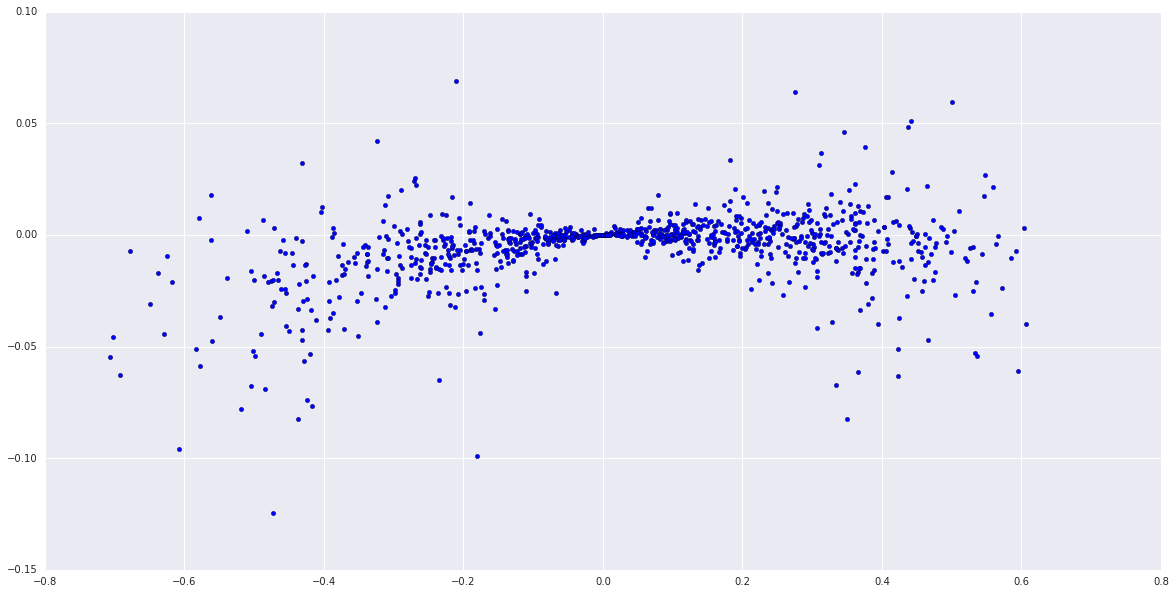

In [141]:
aday = my[my.daily==dailies[1]]
plt.scatter(aday.guess, aday.trade);

In [93]:
dl['guessSum'] = my.groupby('time').guess.sum()
dl['Count'] = my.groupby('time').guess.count()

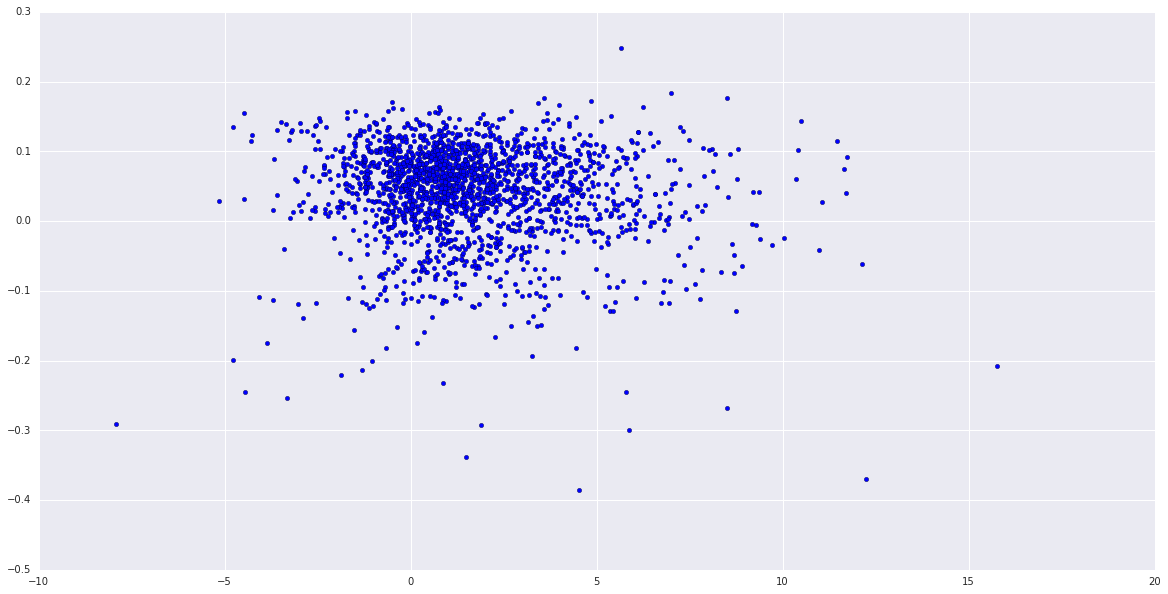

In [98]:
plt.scatter(dl.trade,dl.guessSum/dl.Count);

# COPY PRODUCTION

In [56]:
d.columns

Index(['aikg', 'aIKGZen', 'aIKGHomo', 'aIKGZenTenDraw', 'aIKGHomoTenDraw',
       'aIKGZenVolatility', 'aIKGHomoVolatility', 'aAnother', 'aGlobal',
       'aIKGHomoThree', 'aIKGZenThree', 'aIKGZenThreeVP1',
       'aIKGZenThreeMoreShort', 'as20', 'as21', 'as22', 'as00', 'as10', 'as11',
       'aIKGCover', 'aTryIt', 'aIKGCoverThreeVP1', 'aIKGCoverThreeMoreShort'],
      dtype='object')

In [19]:
def copy_production(names, nbests):
    nl = '\\n'
    for name, nbest in zip(names, nbests):
        ctor = getattr(TP, name[1:])
        if name[0] != 'p': # single
            paramsUse = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,
                             min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0)
            features = f'features = {stringify_list(bigF.query_solo(ctor)[0])}'
        else:
            paramsUse = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,
                             min_sum_hessian_in_leaf=10,lambda_l1=0,lambda_l2=0)
            _f = bigF.query_solo(ctor)[0]
            features = '\n        '.join(x+'_features = '+stringify_list(a) for x,a in zip(['copy','diff','plus','corr'],_f))
        paramsUse.update({'num_iterations': nbest})
        tag = 'vp10' if name[0]=='m' else 'flat'
        guy = f'''\
    class {name}(NamedO()):
        {features}
        feats_ctor = {repr(ctor)}
        train_on = fullhouse
        weight = '{tag}_weight'
        params = {str(O(paramsUse)).replace('<>','dict').replace(' ','')}
            '''
        print(guy[:guy.rindex('\n')])

In [20]:
copy_production(names, nbests)

    class as20(NamedO()):
        features = ["dayOfYear","oo15","aoo15","vp1dd15","volatility60","vp60","fracRecordedDaysSince21","oo10MaxSince21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10MaxSince21{5}","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown20Since21","(oo-aoo)10MaxSince21{5}","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","oo10MaxSince62","oo10Drawdown5Since62","oo10Drawdown10Since62","oo10Drawdown20Since62","oo10MaxSince62{5}","oo10MinSince62","oo10MinSince62{5}","(oo-aoo)10MaxSince62","(oo-aoo)10Drawdown5Since62","(oo-aoo)10Drawdown10Since62","(oo-aoo)10Drawdown20Since62","(oo-aoo)10MaxSince62{5}","(oo-aoo)10MinSince62","(oo-aoo)10MinSince62{5}","oo10MaxSince250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10Drawdown20Since250","oo10MaxSince250{5}","oo10MinSince250","oo10MinSince250{5}","(oo-aoo)10MaxSince250","(oo-aoo)10Drawdown5Since250"

    class as10(NamedO()):
        features = ["cc","oo","dayOfYear","dayOfWeek","volatility60","oo{0/1}","oo{1/2}","oo{1}","oo{2}","(cc-acc){0/1}","(cc-acc){1/2}","(cc-acc){1}","(cc-acc){2}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown(10-5)Since21","oo1MinSince21","oo1MinSince21{5}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown(10-5)Since21","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10Since21","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown1Since21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown(10-5)Since21","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","vp1dd1Since21","vp1dd1MaxSince21{5}","vp1dd1Drawup(20-10)Since21","vp1dd1MinSince21{20}","vp5dd1Since21","vp5dd1MaxSince21{5}","vp5dd1Drawup(20-10)Since21","vp5dd1MinSince21{20}","vp10dd1Since21","vp10dd1MaxSince21{5}","vp10dd1Drawup(20-10)Since21","vp10dd1MinSince21{20

    class aTryIt(NamedO()):
        features = ["oo","aoo","dayOfYear","dayOfWeek","vp10","oo5","oo10","oo15","aoo5","aoo10","aoo15","vp1dd5","vp1dd10","vp1dd15","volatility60","vp20","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","vp1dd(10-5)","vp1dd(15-10)","vp1dd(20-15)","vp1dd(15-5)","vp1dd(20-10)","vp1dd(20-5)","oo{1}","oo{2}","(oo-aoo){1}","(oo-aoo){2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){1}","(aoo-acc){2}","vp1dd","vp1dd{1}","vp1dd{2}","fracRecordedDaysSince21","oo1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown20Since21","oo1Drawdown(10-5)Since21","oo1Drawdown(20-10)Since21","oo1MinSince21","aoo1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1Drawdown20Since21","aoo1Drawdown(10-5)Since21","aoo1Drawdown(20-10)Since21","aoo1MinSince21","oo10Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10Drawdown(10-5)Since21","oo10

    class aIKGCoverThree(NamedO()):
        features = ["assetCodeId","volume","cc","oo","acc","aoo","oo15","aoo15","af","it","rr","af{1}","it{1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it,af,it{1},aoo,acc){0/3}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){0/4}","(it,af,it{1},aoo,acc){1/2}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it{1},af{1},it{2},aoo{1},acc{1}){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it{1},af{1},it{2},aoo{1},acc{1}){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown1

    class ms20(NamedO()):
        features = ["dayOfYear","oo15","aoo15","vp1dd15","volatility60","vp60","fracRecordedDaysSince21","oo10MaxSince21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10MaxSince21{5}","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown20Since21","(oo-aoo)10MaxSince21{5}","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","oo10MaxSince62","oo10Drawdown5Since62","oo10Drawdown10Since62","oo10Drawdown20Since62","oo10MaxSince62{5}","oo10MinSince62","oo10MinSince62{5}","(oo-aoo)10MaxSince62","(oo-aoo)10Drawdown5Since62","(oo-aoo)10Drawdown10Since62","(oo-aoo)10Drawdown20Since62","(oo-aoo)10MaxSince62{5}","(oo-aoo)10MinSince62","(oo-aoo)10MinSince62{5}","oo10MaxSince250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10Drawdown20Since250","oo10MaxSince250{5}","oo10MinSince250","oo10MinSince250{5}","(oo-aoo)10MaxSince250","(oo-aoo)10Drawdown5Since250"

    class ms10(NamedO()):
        features = ["cc","oo","dayOfYear","dayOfWeek","volatility60","oo{0/1}","oo{1/2}","oo{1}","oo{2}","(cc-acc){0/1}","(cc-acc){1/2}","(cc-acc){1}","(cc-acc){2}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown(10-5)Since21","oo1MinSince21","oo1MinSince21{5}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown(10-5)Since21","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10Since21","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown1Since21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown(10-5)Since21","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","vp1dd1Since21","vp1dd1MaxSince21{5}","vp1dd1Drawup(20-10)Since21","vp1dd1MinSince21{20}","vp5dd1Since21","vp5dd1MaxSince21{5}","vp5dd1Drawup(20-10)Since21","vp5dd1MinSince21{20}","vp10dd1Since21","vp10dd1MaxSince21{5}","vp10dd1Drawup(20-10)Since21","vp10dd1MinSince21{20

    class mTryIt(NamedO()):
        features = ["oo","aoo","dayOfYear","dayOfWeek","vp10","oo5","oo10","oo15","aoo5","aoo10","aoo15","vp1dd5","vp1dd10","vp1dd15","volatility60","vp20","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","vp1dd(10-5)","vp1dd(15-10)","vp1dd(20-15)","vp1dd(15-5)","vp1dd(20-10)","vp1dd(20-5)","oo{1}","oo{2}","(oo-aoo){1}","(oo-aoo){2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){1}","(aoo-acc){2}","vp1dd","vp1dd{1}","vp1dd{2}","fracRecordedDaysSince21","oo1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown20Since21","oo1Drawdown(10-5)Since21","oo1Drawdown(20-10)Since21","oo1MinSince21","aoo1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1Drawdown20Since21","aoo1Drawdown(10-5)Since21","aoo1Drawdown(20-10)Since21","aoo1MinSince21","oo10Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10Drawdown(10-5)Since21","oo10

    class mIKGCoverThree(NamedO()):
        features = ["assetCodeId","volume","cc","oo","acc","aoo","oo15","aoo15","af","it","rr","af{1}","it{1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it,af,it{1},aoo,acc){0/3}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){0/4}","(it,af,it{1},aoo,acc){1/2}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it{1},af{1},it{2},aoo{1},acc{1}){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it{1},af{1},it{2},aoo{1},acc{1}){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown1

    class pPairFiveShortVP1_1_0_0_NoCorr(NamedO()):
        copy_features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","vp1dd5","vp1dd10","vp1dd15","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","vp1dd(10-5)","vp1dd(15-10)","vp1dd(20-15)","vp1dd(15-5)","vp1dd(20-10)","vp1dd(20-5)","oo{0/1}","oo{0/2}","oo{1/2}","oo{1}","oo{2}","(oo-cc){0/1}","(oo-cc){0/2}","(oo-cc){1/2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){0/1}","(aoo-acc){0/2}","(aoo-acc){1/2}","(aoo-acc){1}","(aoo-acc){2}","vp1dd{0/1}","vp1dd{0/2}","vp1dd{1/2}","vp1dd","vp1dd{1}","vp1dd{2}"]
diff_features = [""]
plus_features = [""]
corr_features = [""]
        feats_ctor = '<PairFiveShortVP1_1_0_0_NoCorr>0|Return{oo|cc|aoo|acc|doc|daoc|vp1dd}&(\n    <>~Market&(\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|doo|vp1dd|vp5dd|Volatility)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20

# scratch

In [29]:
pZing = '''
    <>~Market & (
        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&
            <>(oo|cc|doo)
            & index[0,1,2, 0:1,1:2]
          }
        | (
            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]})}
            & (
                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}
                | Drawdown[10:,20:]
                | Since{Min&index[20]}
              )
            & Since[21:, 250:]
          )
        | (
            <>Return{dd} & VP[1:, 10:]
            & (
                | Since{Max & index[0]}
                | Drawup[20:,20:10]
                | Since{Min & index[0]}
              )
            & Since[ 62:, 250:]
          )
      )
    | Market{.&
        <>( Weight)
        & (Return| Volatility)
        & [5:]
      }
    |
        <>Return{pure&~dd} & VP[60:]
        | FracRec[62:]
    |
        | Return{rr| af}
#<>#
    <>~Market & (
        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&
            <>(oo|cc|daoc)
            & index[0,1,2, 0:1,1:2,0:2]
          }
        | Return{.&pure&~index} & ~Since & Return{.&
            <>(oo)
            & [18:,9:6,15:12,18:15,12:6,18:12,15:6,18:6,21:9,18:3]
          }
      )
#<>#
0
#<>#
    <>0
    | Corr & Corr{
        <>[21,62]
        & (aoo|aooTEN)
      }
'''

In [33]:
copy = bigF.query_solo(pZing.split('#<>#')[0])[0]
diff = bigF.query_solo(pZing.split('#<>#')[1])[0]
plus = bigF.query_solo(pZing.split('#<>#')[2])[0]
corr = '__corr__aoo_21 __corr__aoo_62 __corr__aooTEN_21 __corr__aooTEN_62'.split()

In [41]:
/print stringify_list(plus)

[""]


In [35]:
/print repr(pZing)

'\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|doo)\n            & index[0,1,2, 0:1,1:2]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]})}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[10:,20:]\n                | Since{Min&index[20]}\n              )\n            & Since[21:, 250:]\n          )\n        | (\n            <>Return{dd} & VP[1:, 10:]\n            & (\n                | Since{Max & index[0]}\n                | Drawup[20:,20:10]\n                | Since{Min & index[0]}\n              )\n            & Since[ 62:, 250:]\n          )\n      )\n    | Market{.&\n        <>( Weight)\n        & (Return| Volatility)\n        & [5:]\n      }\n    |\n        <>Return{pure&~dd} & VP[60:]\n        | FracRec[62:]\n    |\n        | Return{rr| af}\n#<>#\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <

In [309]:
pZing==TP.SearchedPair

False

In [354]:
guys[0,1] # only the FOUR

0.63703449615890917

In [401]:
guys[0,1] # only the FOUR *2

0.63822294856166173